# Calculator REST API Client Tutorial

## Overview

This notebook demonstrates how to interact with a FastAPI calculator service. We'll learn:
- How to make HTTP requests to a local API server
- Different ways to pass parameters
- Error handling for API calls
- Testing and debugging API interactions

## Prerequisites

1. Save the calculator service code as `calculator.py`
2. Install required packages:
   ```bash
   pip install fastapi uvicorn requests
   ```
3. Start the server in a terminal:
   ```bash
   python calculator.py
   ```

The server will run on `http://localhost:9321`

## Understanding the Server Code

Our FastAPI server provides three endpoints:

1. **GET /** - Root endpoint with welcome message
2. **GET /add** - Adds two numbers (parameters: a, b)
3. **GET /subtract** - Subtracts b from a (parameters: a, b)

All endpoints return JSON responses.

In [ ]:
# Import required libraries
import requests
import json
from pprint import pprint
import time
import pandas as pd
import matplotlib.pyplot as plt

# Define the base URL for our API
BASE_URL = "http://localhost:9321"

print(f"API Base URL: {BASE_URL}")

API Base URL: http://localhost:9321


## 1. Testing the Root Endpoint

Let's start by checking if our API is running:

In [ ]:
# Test if the API is running
try:
    response = requests.get(BASE_URL)
    print(f"Status Code: {response.status_code}")
    print(f"Response: {response.json()}")
except requests.exceptions.ConnectionError:
    print("Error: Could not connect to the API.")
    print("Make sure the server is running: python calculator.py")

Status Code: 200
Response: {'message': 'Calculator API is running. Use /add or /subtract endpoints.'}


## 2. Using the Add Endpoint

Now let's use the `/add` endpoint to add two numbers:

In [ ]:
# Method 1: Using query parameters in the URL
url = f"{BASE_URL}/add?a=10&b=5"
response = requests.get(url)

print(f"URL called: {url}")
print(f"Status Code: {response.status_code}")
print(f"Response:")
pprint(response.json())

URL called: http://localhost:9321/add?a=10&b=5
Status Code: 200
Response:
{'a': '10', 'b': '5', 'operation': 'add', 'result': 15.0}


In [4]:
# Method 2: Using params dictionary (recommended)
params = {
    "a": 25.5,
    "b": 14.3
}

response = requests.get(f"{BASE_URL}/add", params=params)

print(f"URL called: {response.url}")
print(f"Status Code: {response.status_code}")
print(f"Response:")
pprint(response.json())

# Extract the result
result = response.json()['result']
print(f"\nThe sum of {params['a']} + {params['b']} = {result}")

URL called: http://localhost:9321/add?a=25.5&b=14.3
Status Code: 200
Response:
{'a': '25.5', 'b': '14.3', 'operation': 'add', 'result': 39.8}

The sum of 25.5 + 14.3 = 39.8


## 3. Using the Subtract Endpoint

Let's test the subtract functionality:

In [5]:
# Subtract example
params = {
    "a": 100,
    "b": 37.5
}

response = requests.get(f"{BASE_URL}/subtract", params=params)

if response.status_code == 200:
    data = response.json()
    print(f"Operation: {data['operation']}")
    print(f"Calculation: {data['a']} - {data['b']} = {data['result']}")
else:
    print(f"Error: {response.status_code}")

Operation: subtract
Calculation: 100 - 37.5 = 62.5


## 4. Error Handling

Let's see what happens with invalid inputs and how to handle errors:

In [6]:
# Test with missing parameters
print("Test 1: Missing parameter 'b'")
response = requests.get(f"{BASE_URL}/add", params={"a": 10})
print(f"Status Code: {response.status_code}")
print(f"Response: {response.text}\n")

# Test with invalid parameters
print("Test 2: Invalid number format")
response = requests.get(f"{BASE_URL}/add", params={"a": "ten", "b": "five"})
print(f"Status Code: {response.status_code}")
print(f"Response: {response.text}\n")

# Test with very large numbers
print("Test 3: Very large numbers")
response = requests.get(f"{BASE_URL}/add", params={"a": 1e100, "b": 1e100})
if response.status_code == 200:
    print(f"Result: {response.json()['result']}")

Test 1: Missing parameter 'b'
Status Code: 422
Response: {"detail":[{"type":"missing","loc":["query","b"],"msg":"Field required","input":null}]}

Test 2: Invalid number format
Status Code: 500
Response: Internal Server Error

Test 3: Very large numbers
Result: 2e+100


## 5. Building a Calculator Client Class

Let's create a reusable client for our calculator API:

In [7]:
class CalculatorClient:
    """
    A client for interacting with the Calculator API
    """
    def __init__(self, base_url="http://localhost:9321"):
        self.base_url = base_url
        self.session = requests.Session()  # Reuse connection
        
    def is_alive(self):
        """Check if the API is running"""
        try:
            response = self.session.get(self.base_url, timeout=2)
            return response.status_code == 200
        except:
            return False
    
    def add(self, a, b):
        """Add two numbers"""
        try:
            response = self.session.get(
                f"{self.base_url}/add",
                params={"a": a, "b": b}
            )
            response.raise_for_status()
            return response.json()['result']
        except requests.exceptions.RequestException as e:
            print(f"Error in add: {e}")
            return None
        except ValueError as e:
            print(f"Invalid input: {e}")
            return None
    
    def subtract(self, a, b):
        """Subtract b from a"""
        try:
            response = self.session.get(
                f"{self.base_url}/subtract",
                params={"a": a, "b": b}
            )
            response.raise_for_status()
            return response.json()['result']
        except requests.exceptions.RequestException as e:
            print(f"Error in subtract: {e}")
            return None
    
    def close(self):
        """Close the session"""
        self.session.close()

# Use the calculator client
calc = CalculatorClient()

if calc.is_alive():
    print("Calculator API is running!\n")
    
    # Perform calculations
    result1 = calc.add(50, 30)
    print(f"50 + 30 = {result1}")
    
    result2 = calc.subtract(100, 45)
    print(f"100 - 45 = {result2}")
    
    # Chain calculations
    result3 = calc.add(result1, result2)
    print(f"{result1} + {result2} = {result3}")
else:
    print("Calculator API is not running!")
    
calc.close()

Calculator API is running!

50 + 30 = 80.0
100 - 45 = 55.0
80.0 + 55.0 = 135.0


## 6. Performance Testing

Let's test the API performance with multiple requests:

In [8]:
# Measure response times
import time

def measure_response_time(url, params, iterations=10):
    """Measure average response time for an endpoint"""
    times = []
    
    for i in range(iterations):
        start = time.time()
        response = requests.get(url, params=params)
        end = time.time()
        
        if response.status_code == 200:
            times.append((end - start) * 1000)  # Convert to milliseconds
    
    return times

# Test add endpoint
add_times = measure_response_time(
    f"{BASE_URL}/add",
    {"a": 100, "b": 200},
    iterations=20
)

# Test subtract endpoint
subtract_times = measure_response_time(
    f"{BASE_URL}/subtract",
    {"a": 500, "b": 123},
    iterations=20
)

# Display statistics
print("Response Time Statistics (in milliseconds):")
print(f"\nAdd Endpoint:")
print(f"  Average: {sum(add_times)/len(add_times):.2f} ms")
print(f"  Min: {min(add_times):.2f} ms")
print(f"  Max: {max(add_times):.2f} ms")

print(f"\nSubtract Endpoint:")
print(f"  Average: {sum(subtract_times)/len(subtract_times):.2f} ms")
print(f"  Min: {min(subtract_times):.2f} ms")
print(f"  Max: {max(subtract_times):.2f} ms")

Response Time Statistics (in milliseconds):

Add Endpoint:
  Average: 2.68 ms
  Min: 2.23 ms
  Max: 3.54 ms

Subtract Endpoint:
  Average: 5.59 ms
  Min: 2.37 ms
  Max: 38.39 ms


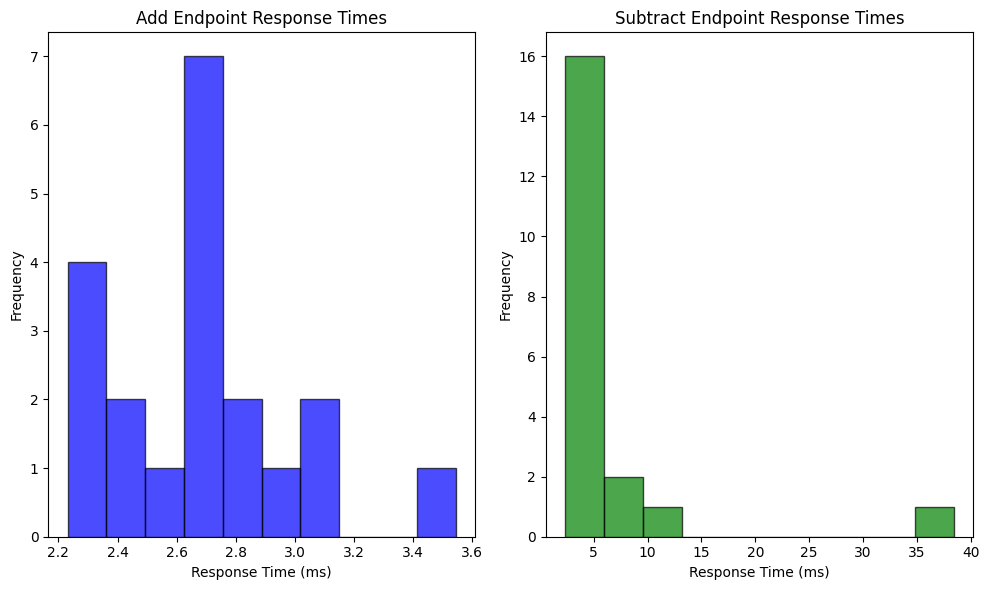

In [9]:
# Visualize response times
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.hist(add_times, bins=10, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Response Time (ms)')
plt.ylabel('Frequency')
plt.title('Add Endpoint Response Times')

plt.subplot(1, 2, 2)
plt.hist(subtract_times, bins=10, alpha=0.7, color='green', edgecolor='black')
plt.xlabel('Response Time (ms)')
plt.ylabel('Frequency')
plt.title('Subtract Endpoint Response Times')

plt.tight_layout()
plt.show()

## 7. Batch Processing Example

Let's process multiple calculations using our API:

In [10]:
# Create a list of calculations
calculations = [
    {"operation": "add", "a": 10, "b": 20},
    {"operation": "subtract", "a": 100, "b": 30},
    {"operation": "add", "a": 5.5, "b": 4.5},
    {"operation": "subtract", "a": 1000, "b": 750},
    {"operation": "add", "a": -10, "b": 5},
    {"operation": "subtract", "a": 0, "b": 100}
]

results = []

for calc in calculations:
    endpoint = f"{BASE_URL}/{calc['operation']}"
    params = {"a": calc['a'], "b": calc['b']}
    
    response = requests.get(endpoint, params=params)
    
    if response.status_code == 200:
        data = response.json()
        results.append({
            "operation": calc['operation'],
            "a": calc['a'],
            "b": calc['b'],
            "result": data['result']
        })

# Display results in a table
df = pd.DataFrame(results)
print("Batch Calculation Results:")
print(df.to_string(index=False))

Batch Calculation Results:
operation      a     b  result
      add   10.0  20.0    30.0
 subtract  100.0  30.0    70.0
      add    5.5   4.5    10.0
 subtract 1000.0 750.0   250.0
      add  -10.0   5.0    -5.0
 subtract    0.0 100.0  -100.0


## 8. Building a Calculator UI Function

Create an interactive calculator function:

In [11]:
def interactive_calculator():
    """
    Simple interactive calculator using the API
    """
    print("=== API Calculator ===")
    print("Operations: add, subtract, quit\n")
    
    while True:
        operation = input("Enter operation (add/subtract/quit): ").lower().strip()
        
        if operation == "quit":
            print("Goodbye!")
            break
        
        if operation not in ["add", "subtract"]:
            print("Invalid operation. Try again.\n")
            continue
        
        try:
            a = float(input("Enter first number: "))
            b = float(input("Enter second number: "))
            
            # Make API call
            response = requests.get(
                f"{BASE_URL}/{operation}",
                params={"a": a, "b": b}
            )
            
            if response.status_code == 200:
                result = response.json()['result']
                symbol = "+" if operation == "add" else "-"
                print(f"\nResult: {a} {symbol} {b} = {result}\n")
            else:
                print(f"Error: {response.status_code}\n")
                
        except ValueError:
            print("Invalid number. Please try again.\n")
        except requests.exceptions.RequestException as e:
            print(f"API Error: {e}\n")

# Uncomment to run the interactive calculator
# interactive_calculator()

## 9. API Documentation with FastAPI

FastAPI automatically generates interactive API documentation:

In [12]:
# FastAPI provides automatic documentation
print("FastAPI Automatic Documentation URLs:")
print(f"\n1. Swagger UI (Interactive docs):")
print(f"   http://localhost:9321/docs")
print(f"\n2. ReDoc (Alternative docs):")
print(f"   http://localhost:9321/redoc")
print(f"\n3. OpenAPI Schema (JSON):")
print(f"   http://localhost:9321/openapi.json")

# Get the OpenAPI schema
try:
    response = requests.get(f"{BASE_URL}/openapi.json")
    if response.status_code == 200:
        schema = response.json()
        print(f"\nAPI Title: {schema['info']['title']}")
        print(f"API Version: {schema['info']['version']}")
        print(f"\nAvailable Paths:")
        for path in schema['paths']:
            print(f"  {path}")
except:
    print("\nCould not fetch OpenAPI schema")

FastAPI Automatic Documentation URLs:

1. Swagger UI (Interactive docs):
   http://localhost:9321/docs

2. ReDoc (Alternative docs):
   http://localhost:9321/redoc

3. OpenAPI Schema (JSON):
   http://localhost:9321/openapi.json

API Title: FastAPI
API Version: 0.1.0

Available Paths:
  /add
  /subtract
  /


## 10. Advanced: Concurrent Requests

Make multiple API calls concurrently for better performance:

In [13]:
import concurrent.futures
import time

def make_calculation(operation, a, b):
    """Make a single calculation via API"""
    response = requests.get(
        f"{BASE_URL}/{operation}",
        params={"a": a, "b": b}
    )
    if response.status_code == 200:
        return response.json()['result']
    return None

# Create many calculations
calculations = [
    ("add", i, i+1) for i in range(20)
] + [
    ("subtract", i*10, i) for i in range(20)
]

# Sequential execution
start_time = time.time()
sequential_results = []
for op, a, b in calculations:
    result = make_calculation(op, a, b)
    sequential_results.append(result)
sequential_time = time.time() - start_time

# Concurrent execution
start_time = time.time()
with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
    futures = [executor.submit(make_calculation, op, a, b) 
               for op, a, b in calculations]
    concurrent_results = [f.result() for f in futures]
concurrent_time = time.time() - start_time

print(f"Sequential execution time: {sequential_time:.2f} seconds")
print(f"Concurrent execution time: {concurrent_time:.2f} seconds")
print(f"Speedup: {sequential_time/concurrent_time:.2f}x")
print(f"\nTotal calculations: {len(calculations)}")
print(f"Results match: {sequential_results == concurrent_results}")

Sequential execution time: 0.11 seconds
Concurrent execution time: 0.09 seconds
Speedup: 1.20x

Total calculations: 40
Results match: True


## Practice Exercises

1. **Add More Operations**: Extend the API to include multiply and divide endpoints
2. **Error Handling**: Improve error handling for division by zero
3. **Caching**: Implement client-side caching for repeated calculations
4. **Authentication**: Add API key authentication to the server
5. **Logging**: Add request logging to track API usage
6. **Rate Limiting**: Implement rate limiting on the server
7. **Complex Calculator**: Add support for operations like power, square root, etc.

## Key Takeaways

- **FastAPI** makes it easy to create REST APIs with automatic documentation
- **Query parameters** are passed in the URL for GET requests
- **JSON responses** are standard for REST APIs
- **Error handling** is crucial for robust client applications
- **Performance testing** helps identify bottlenecks
- **Concurrent requests** can improve performance for multiple API calls
- **Interactive documentation** (Swagger UI) helps explore APIs

## Next Steps

1. Modify the server to add more mathematical operations
2. Implement POST endpoints for complex calculations
3. Add request/response validation with Pydantic models
4. Deploy the API to a cloud service (Heroku, AWS, etc.)
5. Add database integration for storing calculation history